[Working with Spectrum1Ds](https://specutils.readthedocs.io/en/stable/spectrum1d.html)

* @Date: 2024-01-11
* @Author: Rui Zhu

In [111]:
import copy
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

---
# 基本光谱类的创建
* Spectrum1D类是specutils表示光谱的核心对象
* 它既可以表示一条光谱，也可以表示多条光谱
* spectral_axis可以是升序或降序，但在任何一种情况下都必须是单调的。

Text(0, 0.5, 'Flux')

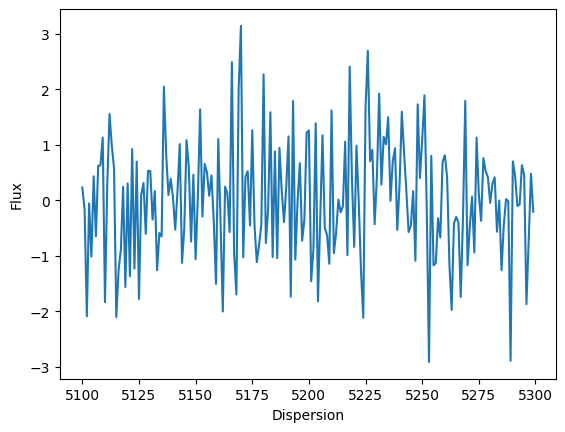

In [2]:
from specutils import Spectrum1D
flux = np.random.randn(200)*u.Jy
wavelength = np.arange(5100, 5300)*u.AA

spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)

ax = plt.subplots()[1]  
ax.plot(spec1d.spectral_axis, spec1d.flux)  
ax.set_xlabel("Dispersion")  
ax.set_ylabel("Flux")

In [4]:
type(spec1d.spectral_axis)

specutils.spectra.spectral_axis.SpectralAxis

---
# 从文件中加载光谱
* https://specutils.readthedocs.io/en/stable/spectrum1d.html#reading-from-a-file
* 内置的加载器类型：https://specutils.readthedocs.io/en/stable/spectrum1d.html#list-of-loaders
* 也可以自己定制一个加载器：https://specutils.readthedocs.io/en/stable/custom_loading.html

In [11]:
path = "/Users/rui/Code/1_Astronote/26_specutils/material/spec-0751-52251-0160.fits"
spec = Spectrum1D.read(path, format="SDSS-III/IV spec")
spec.spectral_axis

<SpectralAxis [3799.2686, 3800.1426, 3801.0188, ..., 9193.905 , 9196.0205, 9198.141 ] Angstrom>

In [27]:
# 使用astroquery获取SDSS光谱数据
from astroquery.sdss import SDSS
specs = SDSS.get_spectra(plate=751, mjd=52251, fiberID=160, data_release=14)
hdul = specs[0]

spec = Spectrum1D.read(specs[0], format="SDSS-III/IV spec") 
spec

<Spectrum1D(flux=<Quantity [30.596626, 33.245728, 35.89512 , ..., 53.27969 , 50.236168,
           51.702717] 1e-17 erg / (Angstrom s cm2)>, spectral_axis=<SpectralAxis [3799.2686, 3800.1426, 3801.0188, ..., 9193.905 , 9196.0205, 9198.141 ] Angstrom>, uncertainty=InverseVariance([0.06440803, 0.        , 0.06292833, ..., 0.2728394 ,
                 0.2806295 , 0.18243204]))>

---
# 将光谱写入文件

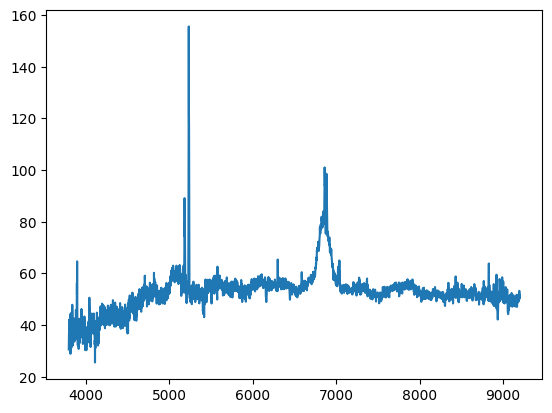

In [29]:
fig, ax = plt.subplots()
ax.plot(spec.spectral_axis, spec.flux)

In [33]:
spec.write("/Users/rui/Downloads/spec.fits", overwrite=True)

/Users/rui/miniconda3/envs/astro/lib/python3.12/site-packages/astropy/nddata/nduncertainty.py:1223: RuntimeWarning: divide by zero encountered in divide
  new_array = None if self.array is None else 1 / self.array


---
# 光谱类的属性

光谱不确定度
* 光谱类支持输入不确定度
* 并且光谱类的算数运算会自动完成不确定度的计算
* uncertainties的数据类型是NDData，因此必须指定其具体类型，而不是数组

In [49]:
from astropy.nddata import StdDevUncertainty

spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA, 
                  flux=np.random.sample(10)*u.Jy, 
                  uncertainty=StdDevUncertainty(np.random.sample(10) * 0.1))
spec

<Spectrum1D(flux=<Quantity [0.09860209, 0.00418147, 0.30077923, 0.59916988, 0.93302162,
           0.44575942, 0.67966177, 0.91924745, 0.58219474, 0.26264329] Jy>, spectral_axis=<SpectralAxis [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>, uncertainty=StdDevUncertainty([0.06329829, 0.02511532, 0.07366453, 0.07485903,
                   0.02661851, 0.00468655, 0.07717829, 0.09739238,
                   0.06999733, 0.05451206]))>

Masks
* mask的数据为True/1(非0都可以)
* 保留的数据为False/0
* mask与NAN是不同的：对于有问题或其它情况不想使用的数据，我们经常使用NAN替换真实数据。但是NAN具有传染性，在之后的运算中对应的数据都是NAN。而mask方法规避了这个问题。

In [51]:
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA, 
                  flux=np.random.sample(10)*u.Jy, 
                  uncertainty=StdDevUncertainty(np.random.sample(10) * 0.1), 
                  mask=[False, False, False, True, True, False, False, False, False, False])
spec.mask

array([False, False, False,  True,  True, False, False, False, False,
       False])

红移与视向速度
* 红移和视向速度的对应关系会自动补充

In [55]:
spec1 = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA, 
                   flux=np.random.sample(10)*u.Jy, 
                   redshift = 0.15)
spec1

<Spectrum1D(flux=<Quantity [0.37869771, 0.80357256, 0.94485862, 0.2652007 , 0.43955147,
           0.63750772, 0.25448491, 0.47775934, 0.84396762, 0.41758984] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=41628.877375672746 km / s
      redshift=0.1499999999999999)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>

In [66]:
spec2 = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA, 
                   flux=np.random.sample(10)*u.Jy, 
                   radial_velocity = 1000*u.Unit("km/s"))
spec2

<Spectrum1D(flux=<Quantity [0.44486976, 0.27176819, 0.48115452, 0.87509106, 0.52084078,
           0.3215099 , 0.85892349, 0.81561884, 0.99955778, 0.11982046] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=1000.0 km / s
      redshift=0.003341222805847144)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>

---
# 移动光谱

In [113]:
# 初始光谱
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA, 
                   flux=np.linspace(1, 10, 10)*u.Jy, 
                   redshift = 0.15)
spec

<Spectrum1D(flux=<Quantity [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=41628.877375672746 km / s
      redshift=0.1499999999999999)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>

将光谱移动到指定的红移位置

In [116]:
spec1 = copy.deepcopy(spec)
spec1.shift_spectrum_to(redshift=0.5)
spec1  # 将光谱移动到指定的红移处

<Spectrum1D(flux=<Quantity [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=115304.79153846155 km / s
      redshift=0.5000000000000002)
  [6521.73913043, 6523.04347826, 6524.34782609, 6525.65217391,
   6526.95652174, 6528.26086957, 6529.56521739, 6530.86956522,
   6532.17391304, 6533.47826087] Angstrom>)>

重新设置光谱类的红移

In [118]:
spec2 = copy.deepcopy(spec)
spec2.set_redshift_to(0.5)
spec2

<Spectrum1D(flux=<Quantity [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=115304.79153846155 km / s
      redshift=0.5000000000000002)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>

---
# 光谱类中的WCS
* specutils包含两种WCS类型：
    1. 可以指定的FITS WCS
    2. 如果不指定FITS WCS将默认使用GWCS

In [127]:
from astropy.wcs import WCS

my_wcs = WCS(header={
    'CDELT1': 1, 'CRVAL1': 6562.8, 'CUNIT1': 'Angstrom', 'CTYPE1': 'WAVE',
    'RESTFRQ': 1400000000, 'CRPIX1': 25})

spec = Spectrum1D(flux=[5,6,7] * u.Jy, wcs=my_wcs)

spec.spectral_axis

<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0
    doppler_rest=1400000000.0 Hz
    doppler_convention=None)
  [6.5388e-07, 6.5398e-07, 6.5408e-07] m>

In [128]:
type(spec.wcs)

astropy.wcs.wcs.WCS

In [129]:
spec = Spectrum1D.read(path, format="SDSS-III/IV spec")
type(spec.wcs)

specutils.utils.wcs_utils.gwcs_from_array.<locals>.SpectralGWCS

---
# 多维数据集
* Spectrum1D可以处理同一个光谱轴，但是多条光谱的情况
* 对于不同光谱轴，不同光谱的情况，需要使用SpetrumCollection类

5

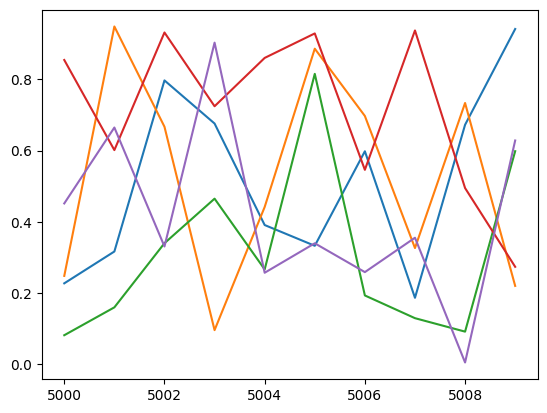

In [141]:
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA,
                  flux=np.random.default_rng(12345).random((5, 10))*u.Jy)

# plot all spectra in the array
fig, ax = plt.subplots()
ax.plot(spec.spectral_axis, spec.flux.T)
len(spec.flux)

---
# 光谱切片

只切割波长

In [144]:
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA,
                  flux=np.random.default_rng(12345).random((5, 10))*u.Jy)

spec_slice = spec[5002*u.AA:5006*u.AA]

spec_slice

<Spectrum1D(flux=<Quantity [[0.79736546, 0.67625467, 0.39110955, 0.33281393],
           [0.66723745, 0.09589794, 0.44183967, 0.88647992],
           [0.34010018, 0.46519315, 0.26642103, 0.8157764 ],
           [0.93198836, 0.72478136, 0.86055132, 0.9293378 ],
           [0.33089093, 0.90345401, 0.25707418, 0.33982834]] Jy>, spectral_axis=<SpectralAxis [5002., 5003., 5004., 5005.] Angstrom>)>

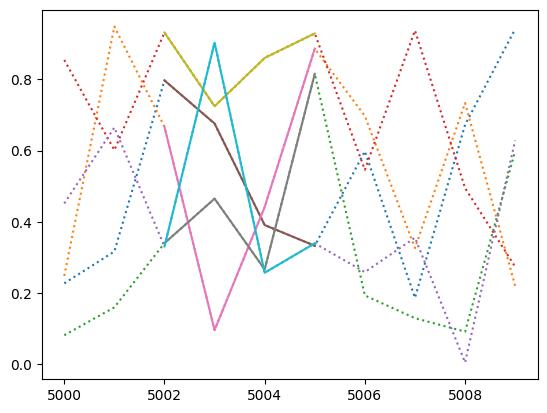

In [151]:
# plot all spectra in the array
fig, ax = plt.subplots()
ax.plot(spec.spectral_axis, spec.flux.T, ls=":");
ax.plot(spec_slice.spectral_axis, spec_slice.flux.T);

在多个光谱中，选择几个光谱进行波长切片

In [153]:
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA,
                  flux=np.random.default_rng(12345).random((5, 10))*u.Jy)

spec_slice = spec[2:4, 5002*u.AA:5006*u.AA]  # 选取第2-3个光谱的5002-5006AA的数据
spec_slice

<Spectrum1D(flux=<Quantity [[0.34010018, 0.46519315, 0.26642103, 0.8157764 ],
           [0.93198836, 0.72478136, 0.86055132, 0.9293378 ]] Jy>, spectral_axis=<SpectralAxis [5002., 5003., 5004., 5005.] Angstrom>)>

包含空间信息的光谱切片

In [158]:
from astropy.coordinates import SpectralCoord, SkyCoord

w = WCS({'WCSAXES': 3, 'CRPIX1': 38.0, 'CRPIX2': 38.0, 'CRPIX3': 1.0,
         'CRVAL1': 205.4384, 'CRVAL2': 27.004754, 'CRVAL3': 4.890499866509344,
         'CTYPE1': 'RA---TAN', 'CTYPE2': 'DEC--TAN', 'CTYPE3': 'WAVE',
         'CUNIT1': 'deg', 'CUNIT2': 'deg', 'CUNIT3': 'um',
         'CDELT1': 3.61111097865634E-05, 'CDELT2': 3.61111097865634E-05, 'CDELT3': 0.001000000047497451,
         'PC1_1 ': -1.0, 'PC1_2 ': 0.0, 'PC1_3 ': 0,
         'PC2_1 ': 0.0, 'PC2_2 ': 1.0, 'PC2_3 ': 0,
         'PC3_1 ': 0, 'PC3_2 ': 0, 'PC3_3 ': 1,
         'DISPAXIS': 2, 'VELOSYS': -2538.02,
         'SPECSYS': 'BARYCENT', 'RADESYS': 'ICRS', 'EQUINOX': 2000.0,
         'LONPOLE': 180.0, 'LATPOLE': 27.004754})

spec = Spectrum1D(flux=np.random.default_rng(12345).random((20, 5, 10)) * u.Jy, wcs=w)  

spec.shape

/Users/rui/miniconda3/envs/astro/lib/python3.12/site-packages/specutils/spectra/spectrum1d.py:203: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"


(10, 5, 20)

In [160]:
lower = [SpectralCoord(4.9, unit=u.um), SkyCoord(ra=205, dec=26, unit=u.deg)]
upper = [SpectralCoord(4.9, unit=u.um), SkyCoord(ra=205.5, dec=27.5, unit=u.deg)]
spec.crop(lower, upper)

<Spectrum1D(flux=<Quantity [[[0.70861236],
            [0.5663815 ],
            [0.0606386 ],
            [0.13811995],
            [0.8974065 ]],

           [[0.97618597],
            [0.870499  ],
            [0.01522275],
            [0.59180312],
            [0.29160346]],

           [[0.13274479],
            [0.99381789],
            [0.767089  ],
            [0.73765335],
            [0.36185756]],

           [[0.09635759],
            [0.38060021],
            [0.63263223],
            [0.60785285],
            [0.4914904 ]],

           [[0.83173506],
            [0.1679683 ],
            [0.39415721],
            [0.25540459],
            [0.39779061]],

           [[0.27625437],
            [0.90381118],
            [0.65453332],
            [0.64141404],
            [0.36941242]],

           [[0.90620901],
            [0.41437874],
            [0.71279457],
            [0.41105785],
            [0.7459662 ]],

           [[0.57160214],
            [0.45227951],
       

---
# 光谱统计与压缩多维光谱

In [170]:
spec = Spectrum1D(spectral_axis=np.arange(5000, 5010)*u.AA,
                  flux=np.random.default_rng(12345).random((5, 10))*u.Jy)
spec.shape  # 多维光谱

(5, 10)

In [181]:
sum = 0
for i in range(5):
    x = spec[i].mean().value
    sum = sum + x
    print(i, x)
sum / 5

0 0.5141239817204386
1 0.5266571323480391
2 0.3141977171666134
3 0.715564207768325
4 0.4195991837440462


0.49802844454949236

In [164]:
spec.mean(), spec.median(), spec.max(), spec.min()  # 计算多维光谱的总的平均值、中位数、最大值、最小值

(<Quantity 0.49802844 Jy>,
 <Quantity 0.45848593 Jy>,
 <Quantity 0.94888115 Jy>,
 <Quantity 0.00502233 Jy>)

In [182]:
# 计算多维光谱中每个光谱的流量平均值
spec.mean(axis='spectral')  

<Quantity [0.51412398, 0.52665713, 0.31419772, 0.71556421, 0.41959918] Jy>

In [183]:
spec.collapse(method=np.nanmean, axis=1) # 同上

<Quantity [0.51412398, 0.52665713, 0.31419772, 0.71556421, 0.41959918] Jy>

In [186]:
# 多维光谱的平均谱
spec.mean(axis='spatial')  

<Spectrum1D(flux=<Quantity [0.37273938, 0.53843905, 0.61351648, 0.57311623, 0.44339915,
           0.66084728, 0.45881921, 0.38715911, 0.39967185, 0.53257671] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>

In [185]:
spec.collapse(method=np.nanmean, axis=0) # 同上

<Spectrum1D(flux=<Quantity [0.37273938, 0.53843905, 0.61351648, 0.57311623, 0.44339915,
           0.66084728, 0.45881921, 0.38715911, 0.39967185, 0.53257671] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [5000., 5001., 5002., 5003., 5004., 5005., 5006., 5007., 5008., 5009.] Angstrom>)>